In [65]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame 
import nltk

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error

# 忽略了警告错误的输出
import warnings
warnings.filterwarnings("ignore")

In [66]:
# df = pd.read_csv('reviews.csv')
df = pd.read_json('reviews_merged.json',lines=True)

In [67]:
# 输出初始时数据
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5,Grammy's Angels Love it,1394841600,"03 15, 2014"
...,...,...,...,...,...,...,...,...,...
278672,A2DG63DN704LOI,B00KKXCJQU,ESlayd,"[0, 1]",I don't normally go ga-ga over a product very ...,5,These have literally changed the way I travel!,1403568000,"06 24, 2014"
278673,A1EVV74UQYVKRY,B00KKXCJQU,K. Groh,"[0, 0]",I've been traveling back and forth to England ...,5,Wonderful for Better Packing,1403740800,"06 26, 2014"
278674,A1UQBFCERIP7VJ,B00KKXCJQU,Margaret Picky,"[1, 1]",These are very nice packing cubes and the 18 x...,5,"Convenient, lightweight, and durable",1402185600,"06 8, 2014"
278675,A22CW0ZHY3NJH8,B00KKXCJQU,Noname,"[2, 2]",I am on vacation with my family of four and th...,5,Holds Up Well In Real World Test,1404691200,"07 7, 2014"


In [78]:
print(df.columns)

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')


### 统计每一个产品（按照asin区分产品）的评论个数并加到后面

In [79]:
count = df.groupby("asin", as_index=False).count()
count

,asin,reviewerID,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,0000031887,23,23,23,23,23,23,23,23
1,0123456479,6,6,6,6,6,6,6,6
2,1608299953,13,13,13,13,13,13,13,13
3,1617160377,16,16,16,16,16,16,16,16
4,B00001W0KA,8,8,8,8,8,8,8,8
...,...,...,...,...,...,...,...,...,...
23028,B00KA602SY,6,6,6,6,6,6,6,6
23029,B00KCWMG5S,5,5,5,5,5,5,5,5
23030,B00KF9180W,10,10,10,10,10,10,10,10
23031,B00KGCLROK,5,5,5,5,5,5,5,5


In [5]:
count = df.groupby("asin", as_index=False).count()
mean = df.groupby("asin", as_index=False).mean()

dfMerged = pd.merge(df, count, how='right', on=['asin'])
dfMerged

,reviewerID_x,asin,reviewerName_x,helpful_x,reviewText_x,overall_x,summary_x,unixReviewTime_x,reviewTime_x,reviewerID_y,reviewerName_y,helpful_y,reviewText_y,overall_y,summary_y,unixReviewTime_y,reviewTime_y
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5,Great tutu- not cheaply made,1297468800,"02 12, 2011",23,23,23,23,23,23,23,23
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5,Very Cute!!,1358553600,"01 19, 2013",23,23,23,23,23,23,23,23
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5,I have buy more than one,1357257600,"01 4, 2013",23,23,23,23,23,23,23,23
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5,"Adorable, Sturdy",1398556800,"04 27, 2014",23,23,23,23,23,23,23,23
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5,Grammy's Angels Love it,1394841600,"03 15, 2014",23,23,23,23,23,23,23,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278672,A2DG63DN704LOI,B00KKXCJQU,ESlayd,"[0, 1]",I don't normally go ga-ga over a product very ...,5,These have literally changed the way I travel!,1403568000,"06 24, 2014",9,9,9,9,9,9,9,9
278673,A1EVV74UQYVKRY,B00KKXCJQU,K. Groh,"[0, 0]",I've been traveling back and forth to England ...,5,Wonderful for Better Packing,1403740800,"06 26, 2014",9,9,9,9,9,9,9,9
278674,A1UQBFCERIP7VJ,B00KKXCJQU,Margaret Picky,"[1, 1]",These are very nice packing cubes and the 18 x...,5,"Convenient, lightweight, and durable",1402185600,"06 8, 2014",9,9,9,9,9,9,9,9
278675,A22CW0ZHY3NJH8,B00KKXCJQU,Noname,"[2, 2]",I am on vacation with my family of four and th...,5,Holds Up Well In Real World Test,1404691200,"07 7, 2014",9,9,9,9,9,9,9,9


In [6]:
#对列重命名
dfMerged["totalReviewers"] = dfMerged["reviewerID_y"]
dfMerged["overallScore"] = dfMerged["overall_x"]
dfMerged["summaryReview"] = dfMerged["summary_x"]

dfNew = dfMerged[['asin','summaryReview','overallScore',"totalReviewers"]]
dfMerged

,reviewerID_x,asin,reviewerName_x,helpful_x,reviewText_x,overall_x,summary_x,unixReviewTime_x,reviewTime_x,reviewerID_y,reviewerName_y,helpful_y,reviewText_y,overall_y,summary_y,unixReviewTime_y,reviewTime_y,totalReviewers,overallScore,summaryReview
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5,Great tutu- not cheaply made,1297468800,"02 12, 2011",23,23,23,23,23,23,23,23,23,5,Great tutu- not cheaply made
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5,Very Cute!!,1358553600,"01 19, 2013",23,23,23,23,23,23,23,23,23,5,Very Cute!!
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5,I have buy more than one,1357257600,"01 4, 2013",23,23,23,23,23,23,23,23,23,5,I have buy more than one
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5,"Adorable, Sturdy",1398556800,"04 27, 2014",23,23,23,23,23,23,23,23,23,5,"Adorable, Sturdy"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5,Grammy's Angels Love it,1394841600,"03 15, 2014",23,23,23,23,23,23,23,23,23,5,Grammy's Angels Love it
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278672,A2DG63DN704LOI,B00KKXCJQU,ESlayd,"[0, 1]",I don't normally go ga-ga over a product very ...,5,These have literally changed the way I travel!,1403568000,"06 24, 2014",9,9,9,9,9,9,9,9,9,5,These have literally changed the way I travel!
278673,A1EVV74UQYVKRY,B00KKXCJQU,K. Groh,"[0, 0]",I've been traveling back and forth to England ...,5,Wonderful for Better Packing,1403740800,"06 26, 2014",9,9,9,9,9,9,9,9,9,5,Wonderful for Better Packing
278674,A1UQBFCERIP7VJ,B00KKXCJQU,Margaret Picky,"[1, 1]",These are very nice packing cubes and the 18 x...,5,"Convenient, lightweight, and durable",1402185600,"06 8, 2014",9,9,9,9,9,9,9,9,9,5,"Convenient, lightweight, and durable"
278675,A22CW0ZHY3NJH8,B00KKXCJQU,Noname,"[2, 2]",I am on vacation with my family of four and th...,5,Holds Up Well In Real World Test,1404691200,"07 7, 2014",9,9,9,9,9,9,9,9,9,5,Holds Up Well In Real World Test


### 选择评论超过100条的产品

In [7]:
dfMerged = dfMerged.sort_values(by='totalReviewers', ascending=False)
dfCount = dfMerged[dfMerged.totalReviewers >= 100]
dfCount

,reviewerID_x,asin,reviewerName_x,helpful_x,reviewText_x,overall_x,summary_x,unixReviewTime_x,reviewTime_x,reviewerID_y,reviewerName_y,helpful_y,reviewText_y,overall_y,summary_y,unixReviewTime_y,reviewTime_y,totalReviewers,overallScore,summaryReview
161700,A205ZO9KZY2ZD2,B005LERHD8,Winnie,"[0, 0]",I was expecting it to be more of a gold tint w...,4,It's ok,1357776000,"01 10, 2013",441,441,441,441,441,441,441,441,441,4,It's ok
161269,A1HFSY6W8LJNJM,B005LERHD8,"Alicia7tommy ""Alicia Andrews""","[0, 0]",The owl necklace is really cute but made real ...,4,Really Cute,1343001600,"07 23, 2012",441,441,441,441,441,441,441,441,441,4,Really Cute
161280,A23L30BKF59BO4,B005LERHD8,Amazon Customer,"[0, 0]",Very pretty. A lot bigger than I expected. I...,4,Very pretty,1357862400,"01 11, 2013",441,441,441,441,441,441,441,441,441,4,Very pretty
161279,A1B1YH4TZ326SX,B005LERHD8,Amazon Customer,"[0, 0]",I order xmcheap jewelry on amazon all the tone...,1,Not worth your money,1393286400,"02 25, 2014",441,441,441,441,441,441,441,441,441,1,Not worth your money
161278,A2AEFSWJCJ8Q6P,B005LERHD8,Amazon Customer,"[0, 0]",I am using it as an acessorie on my first day ...,5,Really pretty!,1376524800,"08 15, 2013",441,441,441,441,441,441,441,441,441,5,Really pretty!
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114084,A3MS6LYDX4G96C,B003YBHF82,SueD,"[0, 0]","My feet are young and healthy, but these shoes...",2,"cute, but not good for my feet",1377820800,"08 30, 2013",100,100,100,100,100,100,100,100,100,2,"cute, but not good for my feet"
114083,A1QWZI0ZB4935J,B003YBHF82,S Martin,"[0, 0]",I had been waiting to get a pair of these.Howe...,5,Crocs Sandal,1389052800,"01 7, 2014",100,100,100,100,100,100,100,100,100,5,Crocs Sandal
114082,A5Y3YCIEMMBY4,B003YBHF82,simplYEEstrong,"[0, 0]","Love these. They are simple, minimal/barefoot...",5,Minimal Yet Comfortable,1351036800,"10 24, 2012",100,100,100,100,100,100,100,100,100,5,Minimal Yet Comfortable
114081,ALZ71M7NBE8O3,B003YBHF82,Shug,"[0, 0]","Have never before owned a pair of Crocs, but t...",5,Excellent,1380153600,"09 26, 2013",100,100,100,100,100,100,100,100,100,5,Excellent


### 按产品ID对所有摘要评论进行分组

In [19]:
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5,Grammy's Angels Love it,1394841600,"03 15, 2014"
...,...,...,...,...,...,...,...,...,...
278672,A2DG63DN704LOI,B00KKXCJQU,ESlayd,"[0, 1]",I don't normally go ga-ga over a product very ...,5,These have literally changed the way I travel!,1403568000,"06 24, 2014"
278673,A1EVV74UQYVKRY,B00KKXCJQU,K. Groh,"[0, 0]",I've been traveling back and forth to England ...,5,Wonderful for Better Packing,1403740800,"06 26, 2014"
278674,A1UQBFCERIP7VJ,B00KKXCJQU,Margaret Picky,"[1, 1]",These are very nice packing cubes and the 18 x...,5,"Convenient, lightweight, and durable",1402185600,"06 8, 2014"
278675,A22CW0ZHY3NJH8,B00KKXCJQU,Noname,"[2, 2]",I am on vacation with my family of four and th...,5,Holds Up Well In Real World Test,1404691200,"07 7, 2014"


In [20]:
dfProductReview = df.groupby("asin", as_index=False).mean()
dfProductReview

,asin,overall,unixReviewTime
0,0000031887,4.608696,1.370064e+09
1,0123456479,4.166667,1.382947e+09
2,1608299953,4.307692,1.307637e+09
3,1617160377,4.625000,1.321078e+09
4,B00001W0KA,4.625000,1.349492e+09
...,...,...,...
23028,B00KA602SY,3.833333,1.404144e+09
23029,B00KCWMG5S,2.400000,1.403585e+09
23030,B00KF9180W,4.800000,1.402661e+09
23031,B00KGCLROK,4.400000,1.403827e+09


In [18]:
dfProductReview = df.groupby("asin", as_index=False).mean()
ProductReviewSummary = dfCount.groupby("asin")["summaryReview"].apply(list)
ProductReviewSummary = pd.DataFrame(ProductReviewSummary)
ProductReviewSummary.to_csv("ProductReviewSummary.csv")
ProductReviewSummary

,summaryReview
asin,
B000072UMJ,"[Love it, Weird sizing on the tag..., Great Sh..."
B0000ANHST,"[It's a carhartt what more can you say, Nice, ..."
B0000C321X,"[NIce fit, nice wash, nice, nada mejor, Levi's..."
B00012O12A,"[Great jeans, What I Excpected., Great seller ..."
B0001ZNZJM,"[Very comforable, The Best Activity Boxer in t..."
...,...
B00D1MR8YU,"[Decent shoe, sizing difference, Cheap, Good f..."
B00DMWQK0W,"[Seahorse!, Very Happy!, Super cute!!, cute, N..."
B00DMWQOYY,"[Kind of a letdown :(, Cute!, Cats., better th..."


In [9]:
dfProductReview

,asin,overall,unixReviewTime
0,0000031887,4.608696,1.370064e+09
1,0123456479,4.166667,1.382947e+09
2,1608299953,4.307692,1.307637e+09
3,1617160377,4.625000,1.321078e+09
4,B00001W0KA,4.625000,1.349492e+09
...,...,...,...
23028,B00KA602SY,3.833333,1.404144e+09
23029,B00KCWMG5S,2.400000,1.403585e+09
23030,B00KF9180W,4.800000,1.402661e+09
23031,B00KGCLROK,4.400000,1.403827e+09


### 对dataframe创建特定列

In [26]:
df3 = pd.read_csv("ProductReviewSummary.csv")
df3 = pd.merge(df3, dfProductReview, on="asin", how='inner')
df3

,asin,summaryReview,overall,unixReviewTime
0,B000072UMJ,"['Love it', 'Weird sizing on the tag...', 'Gre...",4.594595,1.368799e+09
1,B0000ANHST,"[""It's a carhartt what more can you say"", 'Nic...",4.487179,1.371795e+09
2,B0000C321X,"['NIce fit, nice wash', 'nice', 'nada mejor', ...",4.263415,1.363199e+09
3,B00012O12A,"['Great jeans', 'What I Excpected.', 'Great se...",4.153439,1.369221e+09
4,B0001ZNZJM,"['Very comforable', 'The Best Activity Boxer i...",4.472081,1.369226e+09
...,...,...,...,...
87,B00D1MR8YU,"['Decent shoe, sizing difference', 'Cheap, Goo...",3.837398,1.389105e+09
88,B00DMWQK0W,"['Seahorse!', 'Very Happy!', 'Super cute!!', '...",4.298077,1.386893e+09
89,B00DMWQOYY,"['Kind of a letdown :(', 'Cute!', 'Cats.', 'be...",4.119718,1.386733e+09
90,B00DNQIIE8,"[""Exactly Like It's Pictured"", 'Cute', 'These ...",4.228758,1.387839e+09


In [32]:
df3 = df3[['asin','summaryReview','overall']]
df3

,asin,summaryReview,overall
0,B0000ANHST,"[""It's a carhartt what more can you say"", 'Nic...",4.487179
1,B0000C321X,"['NIce fit, nice wash', 'nice', 'nada mejor', ...",4.263415
2,B00012O12A,"['Great jeans', 'What I Excpected.', 'Great se...",4.153439
3,B0001ZNZJM,"['Very comforable', 'The Best Activity Boxer i...",4.472081
4,B0006LMBJ6,"[""If they're made in Mexico, they're great"", '...",4.258929
...,...,...,...
84,B00D1MR8YU,"['Decent shoe, sizing difference', 'Cheap, Goo...",3.837398
85,B00DMWQK0W,"['Seahorse!', 'Very Happy!', 'Super cute!!', '...",4.298077
86,B00DMWQOYY,"['Kind of a letdown :(', 'Cute!', 'Cats.', 'be...",4.119718
87,B00DNQIIE8,"[""Exactly Like It's Pictured"", 'Cute', 'These ...",4.228758


### 对评论列进行文本清理

In [33]:
#用于标记化评论的函数
#匹配以a-z开头的字符串
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    #删除空格
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

In [34]:
#重置索引并删除重复行
df3["summaryClean"] = df3["summaryReview"].apply(cleanReviews)
#Pandas-去除重复项函数drop_duplicates()
df3 = df3.drop_duplicates(['overall'], keep='last')
#重置索引时，将旧索引添加为列，并使用新的顺序索引
df3 = df3.reset_index()
df3

,index,asin,summaryReview,overall,summaryClean
0,0,B0000ANHST,"[""It's a carhartt what more can you say"", 'Nic...",4.487179,it s a carhartt what more can you say nice hea...
1,1,B0000C321X,"['NIce fit, nice wash', 'nice', 'nada mejor', ...",4.263415,nice fit nice wash nice nada mejor levi s orig...
2,2,B00012O12A,"['Great jeans', 'What I Excpected.', 'Great se...",4.153439,great jeans what i excpected great seller and ...
3,3,B0001ZNZJM,"['Very comforable', 'The Best Activity Boxer i...",4.472081,very comforable the best activity boxer in thi...
4,4,B0006LMBJ6,"[""If they're made in Mexico, they're great"", '...",4.258929,if they re made in mexico they re great so far...
...,...,...,...,...,...
84,84,B00D1MR8YU,"['Decent shoe, sizing difference', 'Cheap, Goo...",3.837398,decent shoe sizing difference cheap good for w...
85,85,B00DMWQK0W,"['Seahorse!', 'Very Happy!', 'Super cute!!', '...",4.298077,seahorse very happy super cute cute nautical n...
86,86,B00DMWQOYY,"['Kind of a letdown :(', 'Cute!', 'Cats.', 'be...",4.119718,kind of a letdown cute cats better than expect...
87,87,B00DNQIIE8,"[""Exactly Like It's Pictured"", 'Cute', 'These ...",4.228758,exactly like it s pictured cute these are real...


In [36]:
reviews = df3["summaryClean"] 
# max_features：对所有关键词的term frequency进行降序排序，只取前max_features个作为关键词集
countVector = CountVectorizer(max_features = 300, stop_words='english') 
transformedReviews = countVector.fit_transform(reviews) 

dfReviews = DataFrame(transformedReviews.A, columns=countVector.get_feature_names())
dfReviews = dfReviews.astype(int)
dfReviews

,absolutely,adorable,allegra,amazing,amazon,arch,attractive,awesome,backpack,bad,...,wonderful,work,workout,works,worn,worth,wow,wrong,yes,yoga
0,0,0,0,0,1,0,0,0,0,1,...,1,2,0,0,0,0,0,0,0,0
1,0,0,0,0,2,0,0,3,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,2,0,1,...,1,0,0,0,1,0,0,2,0,0
3,0,0,0,1,1,0,0,6,0,0,...,0,0,0,1,0,3,3,2,0,0
4,0,0,0,0,1,0,0,3,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,0,1,0,0,0,0,0,0,0,1,...,1,0,0,0,0,2,0,0,0,0
85,0,1,0,2,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
86,0,8,0,0,0,0,0,0,0,1,...,1,0,0,0,0,3,0,0,0,0
87,0,4,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,3,0,0


In [37]:
# 保存
dfReviews.to_csv("dfReviews.csv")

In [43]:
# 创建一个名为X的数据集
X = np.array(dfReviews)
# 创建数据集和测试集
tpercent = 0.9
tsize = int(np.floor(tpercent * len(dfReviews)))
dfReviews_train = X[:tsize]
dfReviews_test = X[tsize:]
#数据集和测试集的长度
lentrain = len(dfReviews_train)
lentest = len(dfReviews_test)


9

In [17]:
# KNN分类器寻找相似产品
print(lentrain)
print(lentest)

80
9


In [45]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfReviews_train)

# 为了在对象X中找到每个点的k邻域，需要在对象X上调用kneighbors（）函数
distances, indices = neighbor.kneighbors(dfReviews_train)

In [60]:
# 查找最相关的产品
for i in range(lentest):
    a = neighbor.kneighbors([dfReviews_test[i]])
    related_product_list = a[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", df3["asin"][lentrain + i] ," average rating is ",df3["overall"][lentrain + i])
    print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
    print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B008RUOCJU  average rating is  3.973684210526316
The first similar product is  B007WAEBPQ  average rating is  4.333333333333333
The second similar product is  B004R1II48  average rating is  4.055555555555555
-----------------------------------------------------------
Based on product reviews, for  B008WYDP1C  average rating is  4.257028112449799
The first similar product is  B007WA3K4Y  average rating is  4.209424083769633
The second similar product is  B0083S18LQ  average rating is  3.9565217391304346
-----------------------------------------------------------
Based on product reviews, for  B008X0EW44  average rating is  3.874125874125874
The first similar product is  B007WAEBPQ  average rating is  4.333333333333333
The second similar product is  B0083S18LQ  average rating is  3.9565217391304346
-----------------------------------------------------------
Based on product reviews, for  B009DNWFD0  average rating is  3.8446601941747574
The first similar pr

In [56]:
# 按照格式打印数据
# print ("Based on product reviews, for ", df3["asin"][260] ," average rating is ",df3["overall"][260])
print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
print ("-----------------------------------------------------------")

The first similar product is  B003YBHF82  average rating is  4.21
The second similar product is  B000FH4JJQ  average rating is  4.536363636363636
-----------------------------------------------------------


### 预测评分

In [23]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))

             precision    recall  f1-score   support

          3       1.00      1.00      1.00         3
          4       1.00      1.00      1.00         6

avg / total       1.00      1.00      1.00         9



### 模型的准确性

In [24]:
print (accuracy_score(df5_test_target, knnpreds_test))

1.0


In [25]:
print(mean_squared_error(df5_test_target, knnpreds_test))

0.0


### 用k=5预测评分

In [26]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)
#print (knnpreds_test)

print(classification_report(df5_test_target, knnpreds_test))

             precision    recall  f1-score   support

          3       0.00      0.00      0.00         3
          4       0.62      0.83      0.71         6

avg / total       0.42      0.56      0.48         9



In [27]:
print (accuracy_score(df5_test_target, knnpreds_test))

0.5555555555555556


In [28]:
print(mean_squared_error(df5_test_target, knnpreds_test))

0.4444444444444444


### 预测按85%，15%比例分割的测试集和数据集且k=5的评分

In [29]:
# 创建一个名为X的数据集
X = np.array(dfReviews)
# 创建数据集和测试集
tpercent = 0.85
tsize = int(np.floor(tpercent * len(dfReviews)))
dfReviews_train = X[:tsize]
dfReviews_test = X[tsize:]
#创建数据集和测试集的长度
lentrain = len(dfReviews_train)
lentest = len(dfReviews_test)

In [30]:
# 实例化一个最近邻对象，并将其称为nbrs，然后将其适配到数据集X
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfReviews_train)

# 为了在对象X中找到每个点的k邻域，需要在对象X上调用kneighbors（）函数
distances, indices = neighbor.kneighbors(dfReviews_train)

In [31]:
#查找最相关的产品
for i in range(lentest):
    a = neighbor.kneighbors([dfReviews_test[i]])
    related_product_list = a[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", df3["asin"][lentrain + i] ," average rating is ",df3["overall"][lentrain + i])
    print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
    print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B008RUOCJU  average rating is  3.973684210526316
The first similar product is  B007WAEBPQ  average rating is  4.333333333333333
The second similar product is  B004R1II48  average rating is  4.055555555555555
-----------------------------------------------------------
Based on product reviews, for  B008WYDP1C  average rating is  4.257028112449799
The first similar product is  B007WA3K4Y  average rating is  4.209424083769633
The second similar product is  B0083S18LQ  average rating is  3.9565217391304346
-----------------------------------------------------------
Based on product reviews, for  B008X0EW44  average rating is  3.874125874125874
The first similar product is  B007WAEBPQ  average rating is  4.333333333333333
The second similar product is  B0083S18LQ  average rating is  3.9565217391304346
-----------------------------------------------------------
Based on product reviews, for  B009DNWFD0  average rating is  3.8446601941747574
The first similar pr

In [32]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)
#print (knnpreds_test)

print(classification_report(df5_test_target, knnpreds_test))

             precision    recall  f1-score   support

          3       0.00      0.00      0.00         6
          4       0.57      1.00      0.73         8

avg / total       0.33      0.57      0.42        14



In [33]:
print (accuracy_score(df5_test_target, knnpreds_test))

0.5714285714285714


In [34]:
print(mean_squared_error(df5_test_target, knnpreds_test))

0.42857142857142855


### k=3的kNN，算法的Brute实现

In [35]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='brute').fit(dfReviews_train)

distances, indices = neighbor.kneighbors(dfReviews_train)


In [36]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)
n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df5_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df5_test_target, knnpreds_test))

             precision    recall  f1-score   support

          3       1.00      0.67      0.80         6
          4       0.80      1.00      0.89         8

avg / total       0.89      0.86      0.85        14

Accuracy:  0.8571428571428571
MSE:  0.14285714285714285


### k=5的kNN，算法的KD树实现

In [37]:
neighbor = NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(dfReviews_train)
distances, indices = neighbor.kneighbors(dfReviews_train)

In [38]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)
n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df5_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df5_test_target, knnpreds_test))

             precision    recall  f1-score   support

          3       0.00      0.00      0.00         6
          4       0.57      1.00      0.73         8

avg / total       0.33      0.57      0.42        14

Accuracy:  0.5714285714285714
MSE:  0.42857142857142855


### 基于聚类的词关联

In [50]:
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5,Grammy's Angels Love it,1394841600,"03 15, 2014"
...,...,...,...,...,...,...,...,...,...
278672,A2DG63DN704LOI,B00KKXCJQU,ESlayd,"[0, 1]",I don't normally go ga-ga over a product very ...,5,These have literally changed the way I travel!,1403568000,"06 24, 2014"
278673,A1EVV74UQYVKRY,B00KKXCJQU,K. Groh,"[0, 0]",I've been traveling back and forth to England ...,5,Wonderful for Better Packing,1403740800,"06 26, 2014"
278674,A1UQBFCERIP7VJ,B00KKXCJQU,Margaret Picky,"[1, 1]",These are very nice packing cubes and the 18 x...,5,"Convenient, lightweight, and durable",1402185600,"06 8, 2014"
278675,A22CW0ZHY3NJH8,B00KKXCJQU,Noname,"[2, 2]",I am on vacation with my family of four and th...,5,Holds Up Well In Real World Test,1404691200,"07 7, 2014"


In [54]:
cluster.to_csv("cluster.csv")
cluster1 = pd.read_csv("cluster.csv")
cluster1["summaryClean"] = cluster1["summary"].apply(cleanReviews)
cluster1

,overall,summary,summaryClean
0,1,"['Never GOT IT....', 'DO NOT BUY IF YOU EVER W...",never got it do not buy if you ever want to re...
1,2,"['too short', ""I'm glad i bought back up strap...",too short i m glad i bought back up straps dis...
2,3,"['Came apart in 2weeks!', 'Arrived with a defe...",came apart in weeks arrived with a defect nice...
3,4,"[""It's ok"", 'Good', 'Practically Perfect in ev...",it s ok good practically perfect in every way ...
4,5,"['Great tutu- not cheaply made', 'Very Cute!!...",great tutu not cheaply made very cute i have b...


In [68]:
cluster = df.groupby("overall")["summary"].apply(list)
cluster = pd.DataFrame(cluster)
cluster.to_csv("cluster.csv")
cluster1 = pd.read_csv("cluster.csv")
cluster1["summaryClean"] = cluster1["summary"].apply(cleanReviews)

### 可视化：每个分数组的单词云

In [69]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=30, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

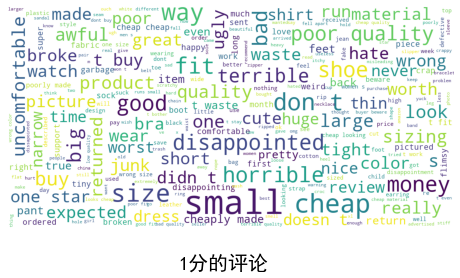

In [70]:
#coding:utf-8  
import matplotlib  
matplotlib.use('qt4agg')  
#指定默认字体  
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  
matplotlib.rcParams['font.family']='sans-serif'  
#解决负号'-'显示为方块的问题  
matplotlib.rcParams['axes.unicode_minus'] = False  

show_wordcloud(cluster1["summaryClean"][0], title = "1分的评论")

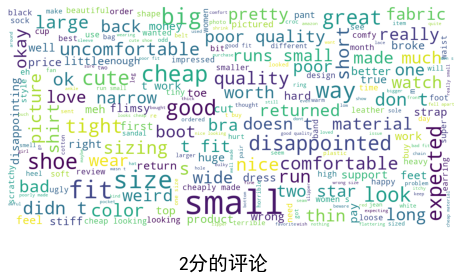

In [71]:
show_wordcloud(cluster1["summaryClean"][1] , title = "2分的评论")

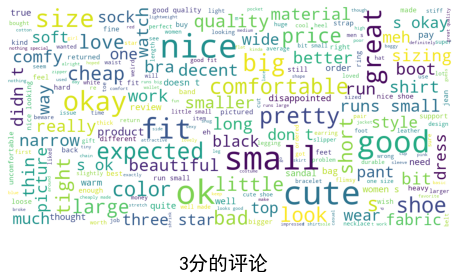

In [72]:
show_wordcloud(cluster1["summaryClean"][2], title = "3分的评论")

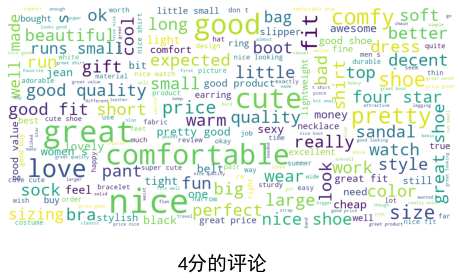

In [73]:
show_wordcloud(cluster1["summaryClean"][3], title = "4分的评论")

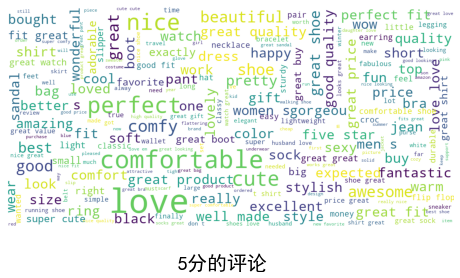

In [76]:
#coding:utf-8  
import matplotlib  
matplotlib.use('qt4agg')  
#指定默认字体  
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  
matplotlib.rcParams['font.family']='sans-serif'  
#解决负号'-'显示为方块的问题  
matplotlib.rcParams['axes.unicode_minus'] = False  

show_wordcloud(cluster1["summaryClean"][4], title = "5分的评论")

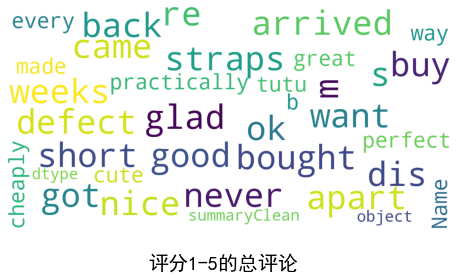

In [75]:
#coding:utf-8  
import matplotlib  
matplotlib.use('qt4agg')  
#指定默认字体  
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  
matplotlib.rcParams['font.family']='sans-serif'  
#解决负号'-'显示为方块的问题  
matplotlib.rcParams['axes.unicode_minus'] = False  

show_wordcloud(cluster1["summaryClean"][:], title = "评分1-5的总评论")